In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, UniPCMultistepScheduler, LMSDiscreteScheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sd_repo = "CompVis/stable-diffusion-v1-4"
clip_repo = 'openai/clip-vit-large-patch14'
device = 'cuda:0'

vae = AutoencoderKL.from_pretrained(sd_repo, subfolder='vae', use_safetensors=True).to(device)
unet = UNet2DConditionModel.from_pretrained(sd_repo, subfolder="unet", use_safetensors=True).to(device)
tokenizer = CLIPTokenizer.from_pretrained(sd_repo, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(sd_repo, subfolder="text_encoder", use_safetensors=True).to(device)

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
scheduler = UniPCMultistepScheduler.from_pretrained(sd_repo, subfolder="scheduler")

In [11]:
prompt = ['Deadpool']
res = 512
num_steps = 25
guidance_scale = 7.5
generator = torch.Generator(device=device)
batch_size = len(prompt)

In [5]:
text_input = tokenizer(
    prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt'
)

# Get CLIP embedding
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]    

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [48]:
scheduler.set_timesteps(num_steps)

latents = torch.randn(
    (batch_size, unet.config.in_channels, res // 8, res // 8),
    generator=generator,
    device=device
)

def step(latents, t):
    
    latent_model_input = torch.cat([latents]*2)
    
    # diffusion step 
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    return latents

for t in tqdm(scheduler.timesteps):
    latents = step(latents, t)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


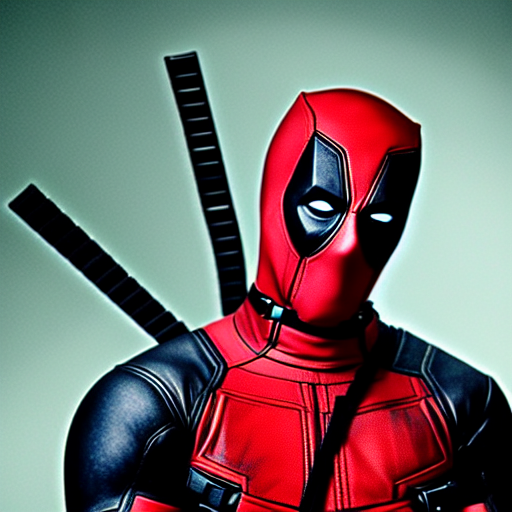

In [49]:
latents_p = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents_p).sample
    
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]